In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


df = pd.read_csv('expanded_personal_transactions.csv')

In [2]:
# Parse and process Date column
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(subset=['Date'], inplace=True)

In [3]:
# Aggregate monthly data
df['YearMonth'] = df['Date'].dt.to_period('M')
df['Credit'] = np.where(df['Transaction Type'] == 'credit', df['Amount'], 0)
df['Debit'] = np.where(df['Transaction Type'] == 'debit', df['Amount'], 0)

In [4]:
monthly_data_income = df.groupby('YearMonth')['Credit'].sum().reset_index()
monthly_data_expenses = df.groupby('YearMonth')['Debit'].sum().reset_index()

In [5]:
# Normalize the data
scaler_income = MinMaxScaler(feature_range=(0, 1))
scaler_expenses = MinMaxScaler(feature_range=(0, 1))
scaled_income = scaler_income.fit_transform(monthly_data_income[['Credit']])
scaled_expenses = scaler_expenses.fit_transform(monthly_data_expenses[['Debit']])

In [6]:
# Create dataset
def create_dataset(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 12
X_income, y_income = create_dataset(scaled_income, window_size)
X_expenses, y_expenses = create_dataset(scaled_expenses, window_size)

In [7]:
# Reshape data for LSTM
X_income = X_income.reshape((X_income.shape[0], X_income.shape[1], 1))
X_expenses = X_expenses.reshape((X_expenses.shape[0], X_expenses.shape[1], 1))

In [8]:
# Split into train and test sets
split_ratio = 0.8
split_idx_income = int(len(X_income) * split_ratio)
split_idx_expenses = int(len(X_expenses) * split_ratio)

In [9]:
X_income_train, X_income_test = X_income[:split_idx_income], X_income[split_idx_income:]
y_income_train, y_income_test = y_income[:split_idx_income], y_income[split_idx_income:]

X_expenses_train, X_expenses_test = X_expenses[:split_idx_expenses], X_expenses[split_idx_expenses:]
y_expenses_train, y_expenses_test = y_expenses[:split_idx_expenses], y_expenses[split_idx_expenses:]

In [10]:
# Build Bidirectional LSTM model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(window_size, 1)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_income = build_model()
model_expenses = build_model()

c:\Users\yudap\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train the models
history_income = model_income.fit(
    X_income_train, y_income_train,
    epochs=555,
    batch_size=32,
    validation_data=(X_income_test, y_income_test),
    verbose=1
)

Epoch 1/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.4066 - mae: 0.6198 - val_loss: 0.0511 - val_mae: 0.1492
Epoch 2/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0288 - mae: 0.1380 - val_loss: 0.1643 - val_mae: 0.3349
Epoch 3/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0997 - mae: 0.2948 - val_loss: 0.0647 - val_mae: 0.1537
Epoch 4/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0208 - mae: 0.1171 - val_loss: 0.0547 - val_mae: 0.1763
Epoch 5/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.0313 - mae: 0.1442 - val_loss: 0.0669 - val_mae: 0.2270
Epoch 6/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0493 - mae: 0.1868 - val_loss: 0.0638 - val_mae: 0.2170
Epoch 7/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0414 - mae: 0.1657 - val_loss: 0.0531 - val_mae: 0.1658
Epoch 8/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0259 - mae: 0.1255 - val_loss: 0.0519 - val_mae: 0.1281
Epoch 9/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.0164 

In [12]:
history_expenses = model_expenses.fit(
    X_expenses_train, y_expenses_train,
    epochs=555,
    batch_size=32,
    validation_data=(X_expenses_test, y_expenses_test),
    verbose=1
)

Epoch 1/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.5610 - mae: 0.7327 - val_loss: 0.0770 - val_mae: 0.1967
Epoch 2/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0302 - mae: 0.1285 - val_loss: 0.2593 - val_mae: 0.4255
Epoch 3/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1140 - mae: 0.3151 - val_loss: 0.1060 - val_mae: 0.1830
Epoch 4/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0212 - mae: 0.1183 - val_loss: 0.0782 - val_mae: 0.2118
Epoch 5/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0260 - mae: 0.1401 - val_loss: 0.0901 - val_mae: 0.2571
Epoch 6/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0457 - mae: 0.1958 - val_loss: 0.0866 - val_mae: 0.2476
Epoch 7/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0409 - mae: 0.1801 - val_loss: 0.0771 - val_mae: 0.2039
Epoch 8/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0208 - mae: 0.1199 - val_loss: 0.0811 - val_mae: 0.1683
Epoch 9/555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0116 - mae: 

In [13]:
# Evaluate the models
train_loss_income, train_mae_income = model_income.evaluate(X_income_train, y_income_train, verbose=0)
test_loss_income, test_mae_income = model_income.evaluate(X_income_test, y_income_test, verbose=0)

train_loss_expenses, train_mae_expenses = model_expenses.evaluate(X_expenses_train, y_expenses_train, verbose=0)
test_loss_expenses, test_mae_expenses = model_expenses.evaluate(X_expenses_test, y_expenses_test, verbose=0)

print(f"Income - Train Loss: {train_loss_income}, Train MAE: {train_mae_income}")
print(f"Income - Test Loss: {test_loss_income}, Test MAE: {test_mae_income}")
print(f"Expenses - Train Loss: {train_loss_expenses}, Train MAE: {train_mae_expenses}")
print(f"Expenses - Test Loss: {test_loss_expenses}, Test MAE: {test_mae_expenses}")

Income - Train Loss: 0.014548521488904953, Train MAE: 0.09700235724449158
Income - Test Loss: 0.05126316472887993, Test MAE: 0.1241021603345871
Expenses - Train Loss: 0.009292648173868656, Train MAE: 0.07694850116968155
Expenses - Test Loss: 0.07721180468797684, Test MAE: 0.1671392023563385


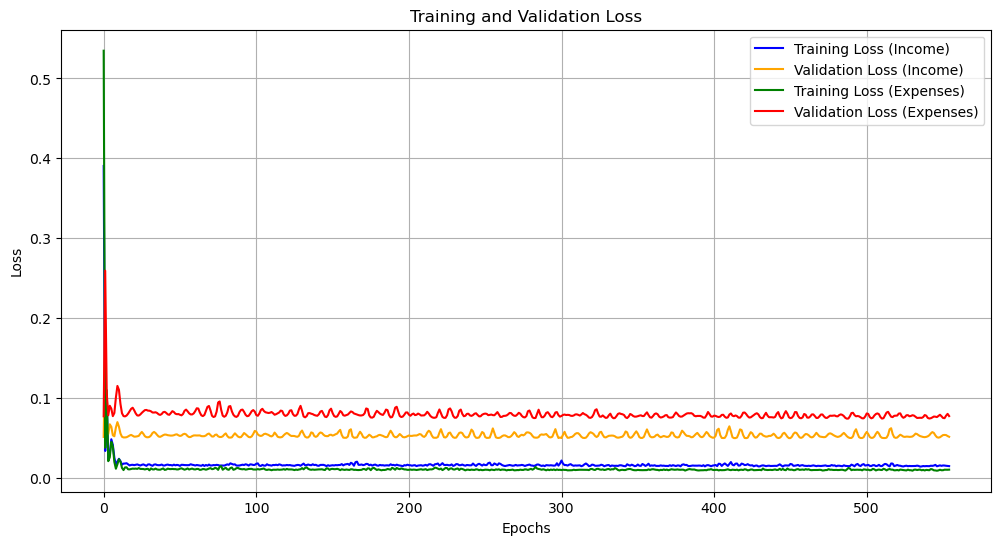

In [14]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_income.history['loss'], label='Training Loss (Income)', color='blue')
plt.plot(history_income.history['val_loss'], label='Validation Loss (Income)', color='orange')
plt.plot(history_expenses.history['loss'], label='Training Loss (Expenses)', color='green')
plt.plot(history_expenses.history['val_loss'], label='Validation Loss (Expenses)', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

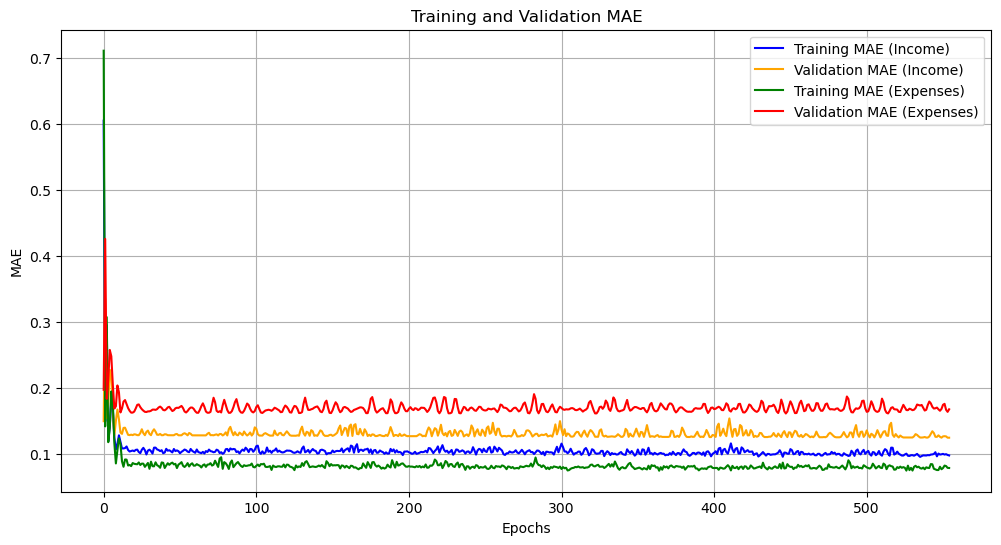

In [15]:
# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history_income.history['mae'], label='Training MAE (Income)', color='blue')
plt.plot(history_income.history['val_mae'], label='Validation MAE (Income)', color='orange')
plt.plot(history_expenses.history['mae'], label='Training MAE (Expenses)', color='green')
plt.plot(history_expenses.history['val_mae'], label='Validation MAE (Expenses)', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Make predictions
pred_income = model_income.predict(X_income_test)
pred_expenses = model_expenses.predict(X_expenses_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


In [17]:
# Denormalize predictions
denorm_income = scaler_income.inverse_transform(pred_income)
denorm_actual_income = scaler_income.inverse_transform(y_income_test.reshape(-1, 1))

denorm_expenses = scaler_expenses.inverse_transform(pred_expenses)
denorm_actual_expenses = scaler_expenses.inverse_transform(y_expenses_test.reshape(-1, 1))

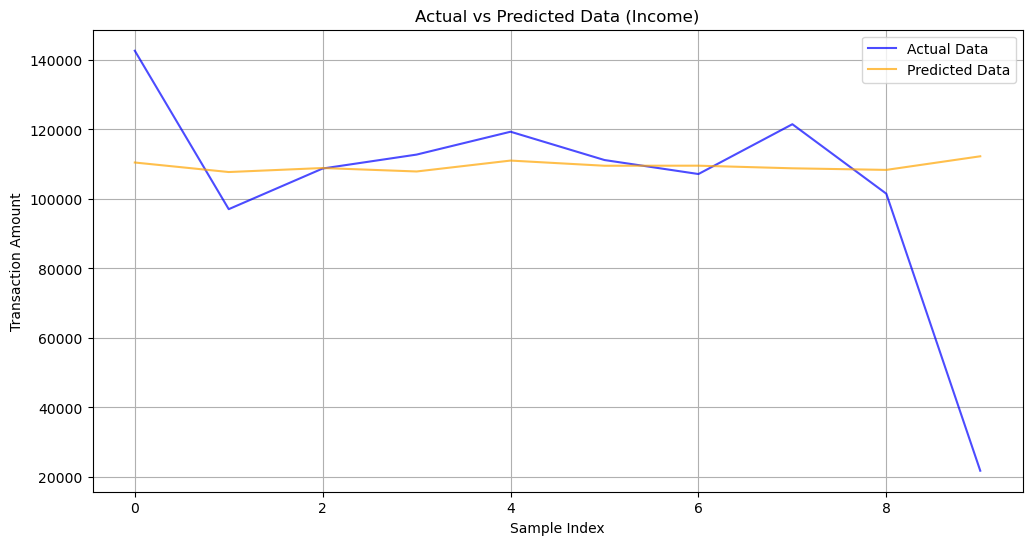

In [19]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(denorm_actual_income, label='Actual Data', color='blue', alpha=0.7)
plt.plot(denorm_income, label='Predicted Data', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Data (Income)')
plt.xlabel('Sample Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

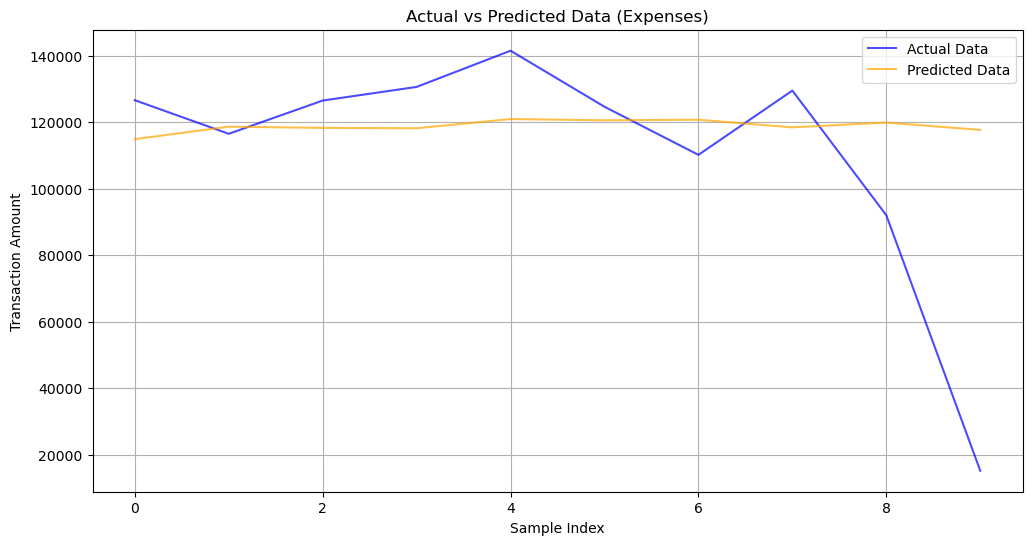

In [20]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(denorm_actual_expenses, label='Actual Data', color='blue', alpha=0.7)
plt.plot(denorm_expenses, label='Predicted Data', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Data (Expenses)')
plt.xlabel('Sample Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Forecast future income and expenses
def forecast_future(model, scaler, last_window, steps=12):
    future_input = last_window.reshape(1, window_size, 1)
    forecast = []
    for _ in range(steps):
        pred = model.predict(future_input)
        forecast.append(pred[0, 0])
        future_input = np.append(future_input[:, 1:, :], [[pred[0]]], axis=1)
    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

future_income = forecast_future(model_income, scaler_income, X_income[-1])
future_expenses = forecast_future(model_expenses, scaler_expenses, X_expenses[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


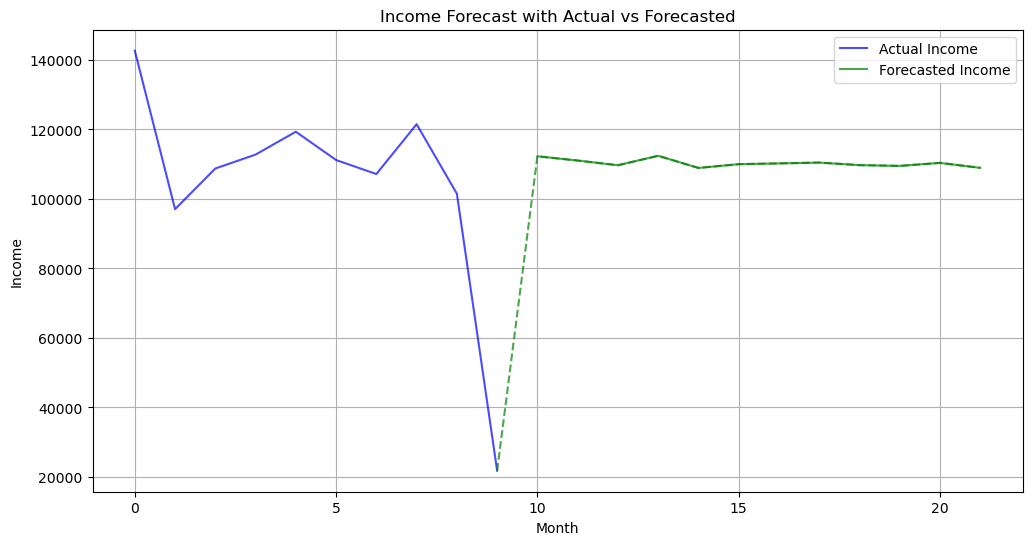

In [22]:
# Plot forecasted income and actual income with connected lines
plt.figure(figsize=(12, 6))
plt.plot(denorm_actual_income, label='Actual Income', color='blue', alpha=0.7)
plt.plot(range(len(denorm_actual_income), len(denorm_actual_income) + 12), future_income, label='Forecasted Income', color='green', alpha=0.7)

# Connect actual and forecasted income
plt.plot(range(len(denorm_actual_income) - 1, len(denorm_actual_income) + 12), 
         np.concatenate([denorm_actual_income[-1:], future_income]), color='green', linestyle='--', alpha=0.7)

plt.legend()
plt.title('Income Forecast with Actual vs Forecasted')
plt.xlabel('Month')
plt.ylabel('Income')
plt.grid(True)
plt.show()


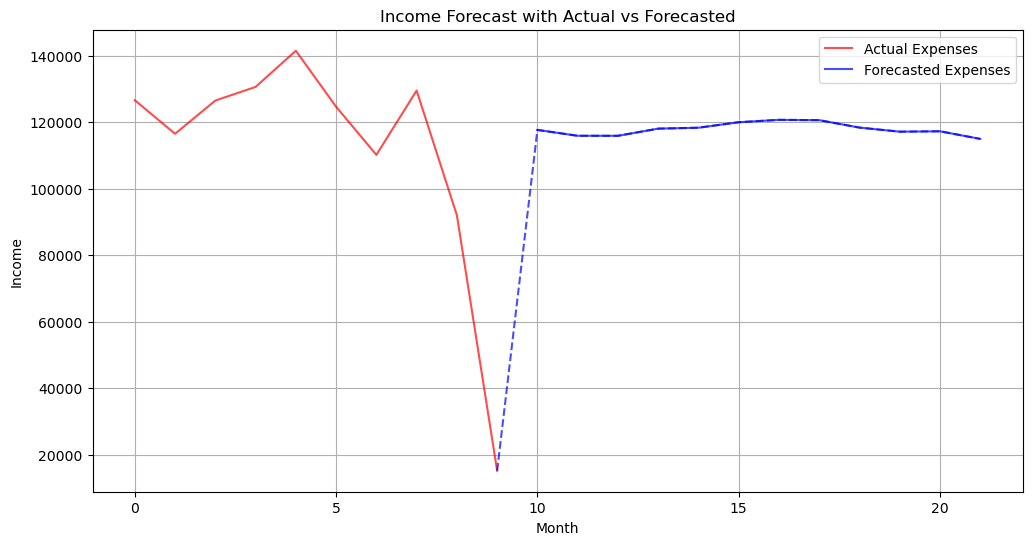

In [23]:
# Plot forecasted income and actual income with connected lines
plt.figure(figsize=(12, 6))
plt.plot(denorm_actual_expenses, label='Actual Expenses', color='red', alpha=0.7)
plt.plot(range(len(denorm_actual_expenses), len(denorm_actual_expenses) + 12), future_expenses, label='Forecasted Expenses', color='blue', alpha=0.7)

# Connect actual and forecasted income
plt.plot(range(len(denorm_actual_expenses) - 1, len(denorm_actual_expenses) + 12), 
         np.concatenate([denorm_actual_expenses[-1:], future_expenses]), color='blue', linestyle='--', alpha=0.7)

plt.legend()
plt.title('Income Forecast with Actual vs Forecasted')
plt.xlabel('Month')
plt.ylabel('Income')
plt.grid(True)
plt.show()


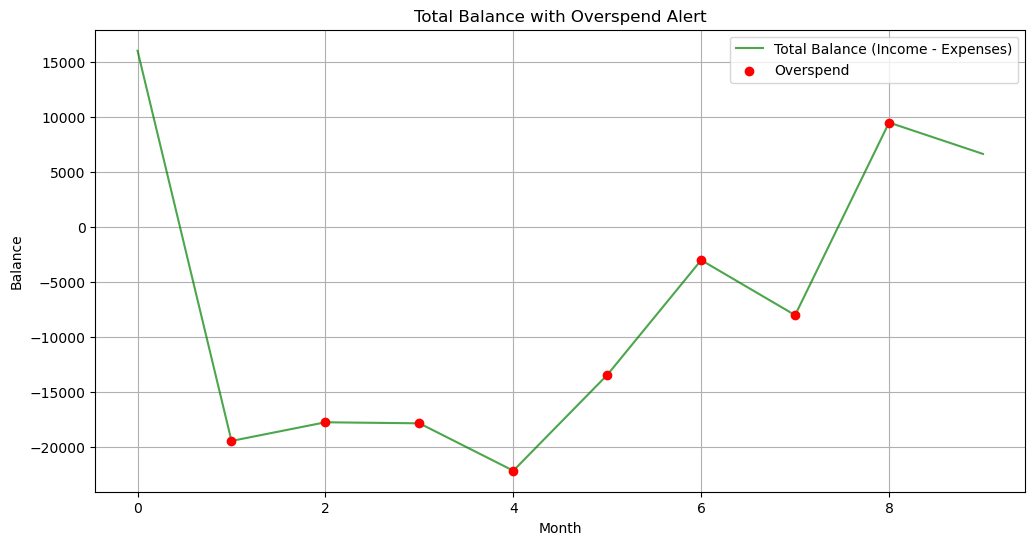

In [24]:
# Calculate total balance each month
total_balance = denorm_actual_income - denorm_actual_expenses

# Initialize lists to store overspend points
overspend_points = []

# Check overspend for the last month and the previous month
for i in range(1, len(total_balance)):
    # Check for overspend (balance < 20% of income for that month)
    if total_balance[i] < 0.2 * denorm_actual_income[i]:
        overspend_points.append(i)
        
# Check overspend for the last month
if total_balance[-1] < 0.2 * denorm_actual_income[-1]:
    overspend_points.append(len(total_balance) - 1)

# Plot total balance
plt.figure(figsize=(12, 6))
plt.plot(total_balance, label='Total Balance (Income - Expenses)', color='green', alpha=0.7)

# Plot overspend points as red dots
plt.scatter(overspend_points, total_balance[overspend_points], color='red', label='Overspend', zorder=5)

# Title and labels
plt.title('Total Balance with Overspend Alert')
plt.xlabel('Month')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)
plt.show()

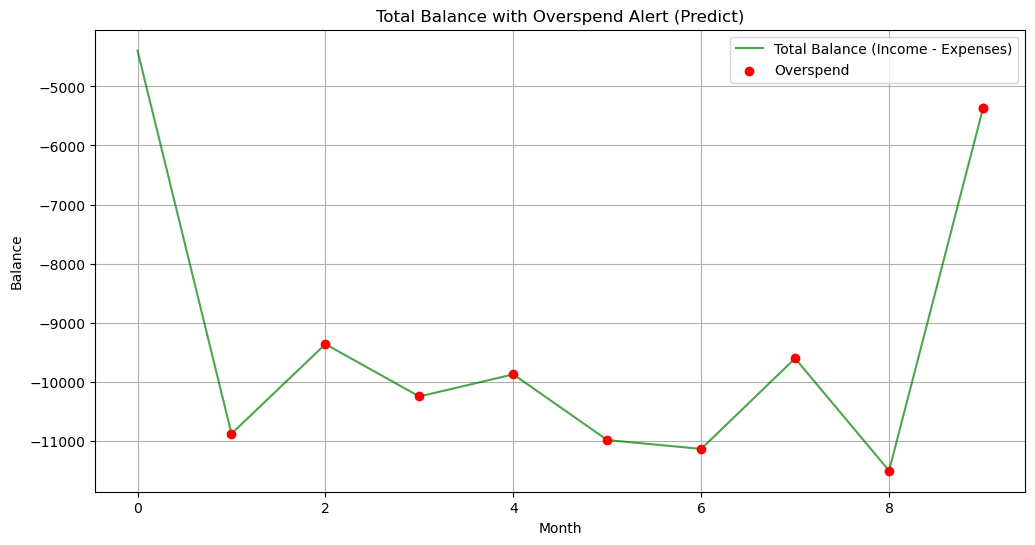

In [25]:
# Calculate total balance each month
total_balance = denorm_income - denorm_expenses

# Initialize lists to store overspend points
overspend_points = []

# Check overspend for the last month and the previous month
for i in range(1, len(total_balance)):
    # Check for overspend (balance < 20% of income for that month)
    if total_balance[i] < 0.2 * denorm_income[i]:
        overspend_points.append(i)
        
# Check overspend for the last month
if total_balance[-1] < 0.2 * denorm_income[-1]:
    overspend_points.append(len(total_balance) - 1)

# Plot total balance
plt.figure(figsize=(12, 6))
plt.plot(total_balance, label='Total Balance (Income - Expenses)', color='green', alpha=0.7)

# Plot overspend points as red dots
plt.scatter(overspend_points, total_balance[overspend_points], color='red', label='Overspend', zorder=5)

# Title and labels
plt.title('Total Balance with Overspend Alert (Predict)')
plt.xlabel('Month')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)
plt.show()

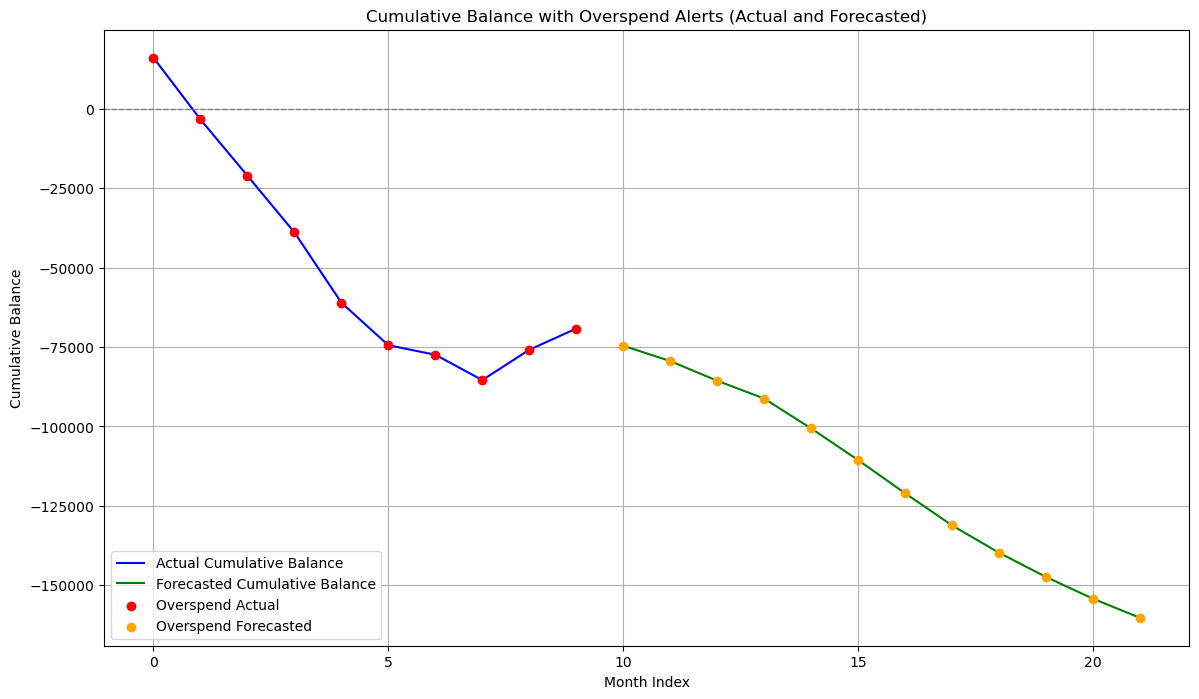

In [26]:
# Recalculate cumulative balances
actual_cumulative_balance = np.cumsum(denorm_actual_income - denorm_actual_expenses).flatten()
forecasted_cumulative_balance = (
    np.cumsum(future_income - future_expenses).flatten() + actual_cumulative_balance[-1]
)

# Detect overspend points
overspend_actual = [
    i for i, balance in enumerate(actual_cumulative_balance) 
    if balance < 0.2 * denorm_actual_income[i]
]

overspend_forecasted = [
    i for i, balance in enumerate(forecasted_cumulative_balance) 
    if balance < 0.2 * future_income[i]
]

# Plot cumulative balance with overspend alerts
plt.figure(figsize=(14, 8))
plt.plot(actual_cumulative_balance, label='Actual Cumulative Balance', color='blue')
plt.plot(range(len(denorm_actual_income), len(denorm_actual_income) + 12), 
         forecasted_cumulative_balance, label='Forecasted Cumulative Balance', color='green')

# Mark overspend points
plt.scatter(overspend_actual, [actual_cumulative_balance[i] for i in overspend_actual], 
            color='red', label='Overspend Actual', zorder=5)
plt.scatter([x + len(denorm_actual_income) for x in overspend_forecasted], 
            [forecasted_cumulative_balance[x] for x in overspend_forecasted], 
            color='orange', label='Overspend Forecasted', zorder=5)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Cumulative Balance with Overspend Alerts (Actual and Forecasted)')
plt.xlabel('Month Index')
plt.ylabel('Cumulative Balance')
plt.legend()
plt.grid(True)
plt.show()


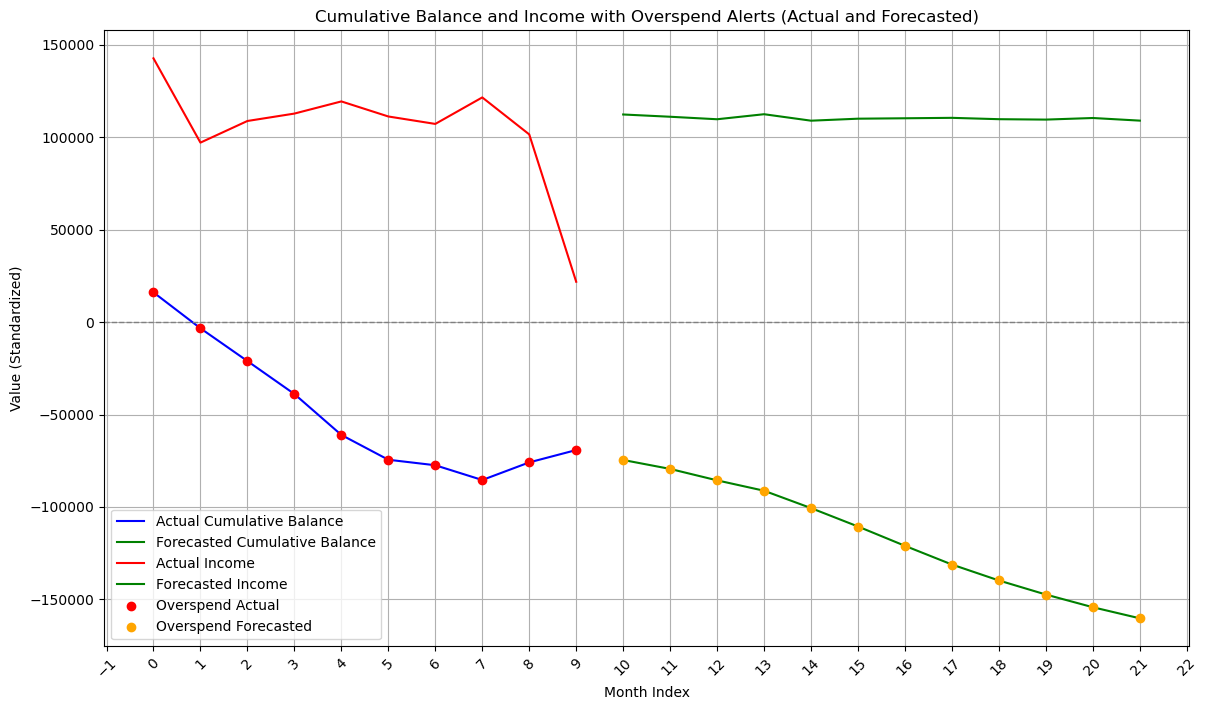

In [27]:
# Plot cumulative balance with overspend alerts and incomes
plt.figure(figsize=(14, 8))

# Plot cumulative balances
plt.plot(actual_cumulative_balance, label='Actual Cumulative Balance', color='blue')
plt.plot(range(len(denorm_actual_income), len(denorm_actual_income) + 12), 
         forecasted_cumulative_balance, label='Forecasted Cumulative Balance', color='green')

# Plot incomes
plt.plot(denorm_actual_income, label='Actual Income', color='red')
plt.plot(range(len(denorm_actual_income), len(denorm_actual_income) + 12), 
         future_income, label='Forecasted Income', color='green')

# Mark overspend points
plt.scatter(overspend_actual, [actual_cumulative_balance[i] for i in overspend_actual], 
            color='red', label='Overspend Actual', zorder=5)
plt.scatter([x + len(denorm_actual_income) for x in overspend_forecasted], 
            [forecasted_cumulative_balance[x] for x in overspend_forecasted], 
            color='orange', label='Overspend Forecasted', zorder=5)

# Draw horizontal zero line
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Title and axis labels
plt.title('Cumulative Balance and Income with Overspend Alerts (Actual and Forecasted)')
plt.xlabel('Month Index')
plt.ylabel('Value (Standardized)')

# Set x-axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [28]:
import pickle
# Simpan scaler ke file
with open('scaler_income.pkl', 'wb') as f:
    pickle.dump(scaler_income, f)

# Simpan model
model_income.save('model_income.h5')

In [29]:
# Simpan scaler ke file
with open('scaler_expenses.pkl', 'wb') as f:
    pickle.dump(scaler_expenses, f)

# Simpan model
model_expenses.save('model_expenses.h5')